In [1]:
#stacking sur les deux model prophet et lightgbm 
# perf respective : 0.70 , 0.49

In [2]:
import pandas as pd
import numpy as np
import tqdm

from numpy import std

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import TimeSeriesSplit
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import StackingRegressor

from sklearn.metrics import mean_squared_error

import lightgbm as lgbm
from fbprophet import Prophet

import matplotlib.pyplot as plt


In [3]:
from metric_calcul.WRMSSE import WRMSSEEvaluator

In [4]:
def get_lb_rank(score):
    """
    score de la LB depuis le fichier de la leaderboard fourni par kaggle
    """
    df_lb = pd.read_csv("/Users/jerem/cours_esiee_paris/E4/kaggle_walmart/data/datasets_687702_1205782_m5-forecasting-accuracy-publicleaderboard-rank.csv")

    return (df_lb.Score <= score).sum() + 1

In [5]:
## data
df_train_full = pd.read_csv("/Users/jerem/cours_esiee_paris/E4/kaggle_walmart/data/sales_train_evaluation.csv")

df_calendar = pd.read_csv("/Users/jerem/cours_esiee_paris/E4/kaggle_walmart/data/calendar.csv")
df_prices = pd.read_csv("/Users/jerem/cours_esiee_paris/E4/kaggle_walmart/data/sell_prices.csv")
df_sample_submission = pd.read_csv("/Users/jerem/cours_esiee_paris/E4/kaggle_walmart/data/sample_submission.csv")
df_sample_submission["order"] = range(df_sample_submission.shape[0])

df_train = df_train_full.iloc[:, :-28]
df_valid = df_train_full.iloc[:, -28:]

In [6]:
evaluator = WRMSSEEvaluator(df_train, df_valid, df_calendar, df_prices)

In [7]:
#import des deux models à stack 
light_df = pd.read_csv('/Users/jerem/cours_esiee_paris/E4/kaggle_walmart/submission/submission_1_all_data.csv')

In [8]:
prophet_df = pd.read_csv('/Users/jerem/cours_esiee_paris/E4/kaggle_walmart/submission/prophet_tuned_without_eval_computed.csv')
prophet_df = prophet_df.drop('Unnamed: 0',axis=1)

In [9]:
light_df.set_index('id',inplace=True)
light_df.head()

,F1,F2,F3,F4,F5,F6,F7,F8,F9,F10,...,F19,F20,F21,F22,F23,F24,F25,F26,F27,F28
id,,,,,,,,,,,,,,,,,,,,,
FOODS_1_001_CA_1_validation,0.913235,0.827773,0.819731,0.795553,1.049908,1.189933,1.169151,0.985722,0.944810,0.950615,...,1.061990,1.313827,1.215845,0.953166,0.851623,0.837490,0.851408,1.019072,1.255848,1.241322
FOODS_1_001_CA_2_validation,0.953068,1.072191,0.958676,1.116954,1.153383,1.506220,1.364111,0.930627,0.916615,0.907662,...,1.135599,1.509597,1.478175,1.020680,0.964297,0.962438,0.963363,1.196510,1.645398,1.346751
FOODS_1_001_CA_3_validation,1.128027,1.075911,0.912882,0.886881,0.960791,1.125676,1.226875,1.061736,1.076449,0.935067,...,1.034299,1.497057,1.659610,1.141541,1.059402,0.902611,0.892723,0.966101,1.250934,1.292633
FOODS_1_001_CA_4_validation,0.398870,0.353666,0.351945,0.355953,0.418473,0.431137,0.497521,0.392819,0.413391,0.400593,...,0.438389,0.469421,0.476798,0.373327,0.364115,0.366365,0.373522,0.422287,0.467946,0.470816
FOODS_1_001_TX_1_validation,0.198043,0.192291,0.184541,0.186598,0.196933,0.199780,0.238182,0.525956,0.491990,0.477307,...,0.396754,0.378252,0.351230,0.287096,0.278369,0.274433,0.274933,0.298888,0.349390,0.329039


In [10]:
prophet_df.set_index('id',inplace=True)
prophet_df = prophet_df.reindex(index=light_df.index)

In [11]:
prophet_df.head()

,F1,F2,F3,F4,F5,F6,F7,F8,F9,F10,...,F19,F20,F21,F22,F23,F24,F25,F26,F27,F28
id,,,,,,,,,,,,,,,,,,,,,
FOODS_1_001_CA_1_validation,0.801172,0.496831,0.824167,1.041874,1.010738,1.079818,0.981558,0.875276,0.486844,0.635043,...,0.344994,0.658600,0.787525,0.739873,0.284143,0.400917,0.507762,0.520365,0.710190,0.710210
FOODS_1_001_CA_2_validation,1.303677,1.209265,0.752748,0.697430,0.139253,0.634507,0.612838,0.498415,0.592074,0.299601,...,1.006725,1.696680,1.686970,1.524537,1.664273,1.564578,1.932489,1.740356,2.448872,2.488462
FOODS_1_001_CA_3_validation,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.583423,0.000000,0.000000,0.197375,...,0.000000,0.666035,2.240984,0.851614,0.706428,0.736940,0.704921,1.171633,1.390400,2.154739
FOODS_1_001_CA_4_validation,0.747951,0.376488,0.620451,0.570586,0.523577,0.452158,0.315186,0.560178,0.210937,0.493671,...,0.000000,0.000000,0.000000,0.250329,0.000000,0.172117,0.135284,0.178982,0.281301,0.321347
FOODS_1_001_TX_1_validation,0.211350,0.431709,0.227418,0.242261,0.017164,0.155282,0.206174,0.498253,0.834908,0.593471,...,0.615440,0.709686,0.398820,0.191124,0.207573,0.000000,0.155870,0.070914,0.159278,0.000000


In [12]:
def test_all_alpha(light,prophet):
    '''retourne une dataframe des scores des differents alpha testés'''
    
    w1_list = list()
    w2_list = list()
    score_list = list()
    
    for w1 in np.linspace(0,1,21):


        w2 = 1.0 - w1
        light_prophet = w1*light + w2*prophet
        light_prophet = light_prophet.reset_index()
        
        
        preds_valid = light_prophet
        preds_valid = preds_valid[preds_valid.id.str.contains("validation")]
        preds_valid = preds_valid.merge(df_sample_submission[["id", "order"]], on = "id").sort_values("order").drop(["id", "order"], axis = 1).reset_index(drop = True)
        preds_valid.rename(columns = {
            "F1": "d_1914", "F2": "d_1915", "F3": "d_1916", "F4": "d_1917", "F5": "d_1918", "F6": "d_1919", "F7": "d_1920",
            "F8": "d_1921", "F9": "d_1922", "F10": "d_1923", "F11": "d_1924", "F12": "d_1925", "F13": "d_1926", "F14": "d_1927",
            "F15": "d_1928", "F16": "d_1929", "F17": "d_1930", "F18": "d_1931", "F19": "d_1932", "F20": "d_1933", "F21": "d_1934",
            "F22": "d_1935", "F23": "d_1936", "F24": "d_1937", "F25": "d_1938", "F26": "d_1939", "F27": "d_1940", "F28": "d_1941"
        }, inplace = True)

        groups, scores = evaluator.score(preds_valid)

        score = np.mean(scores)
        
        w1_list.append(w1)
        w2_list.append(w2)
        score_list.append(score)
    
    alpha_dict = {"w1":w1_list, "w2":w2_list,"score": score_list}
    
    score_alpha = pd.DataFrame(alpha_dict)
    
    return score_alpha

In [13]:
verdict = test_all_alpha(light_df,prophet_df)

In [14]:
verdict

,w1,w2,score
0,0.00,1.00,0.701414
1,0.05,0.95,0.685195
2,0.10,0.90,0.669343
3,0.15,0.85,0.653889
4,0.20,0.80,0.638862
5,0.25,0.75,0.624296
6,0.30,0.70,0.610229
7,0.35,0.65,0.596701
8,0.40,0.60,0.583758
9,0.45,0.55,0.571449


In [114]:
import seaborn as sns

cm = sns.light_palette("blue", as_cmap=True)
x=verdict
x=x.style.background_gradient(cmap=cm)
display(x)

,w1,w2,score
0,0,1,0.701414
1,0.05,0.95,0.685195
2,0.1,0.9,0.669343
3,0.15,0.85,0.653889
4,0.2,0.8,0.638862
5,0.25,0.75,0.624296
6,0.3,0.7,0.610229
7,0.35,0.65,0.596701
8,0.4,0.6,0.583758
9,0.45,0.55,0.571449


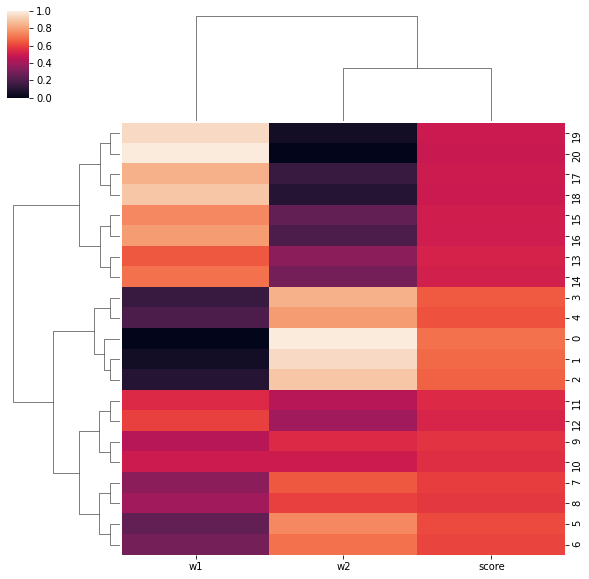

In [15]:
# Libraries
import seaborn as sns
import pandas as pd
from matplotlib import pyplot as plt
 
# Data set

#df = df.set_index('model')
#del df.index.name
#df
 
# Default plot
sns.clustermap(verdict)
